# NON-LINEAR ML TECHNIQUES

In [1]:
# libraries
import pandas as pd 
import math
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn import metrics
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster,ReducedForecaster
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xg
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable 
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D" 

file_name = "cta_ridership.csv"
time_dependent_variable = "total_rides"
time_column = "service_date"
frmt =  '%Y-%m-%d'
X = "D"

### Reading the csv file

In [3]:
def data(time_column, file_name, frmt='%Y-%m-%d %H:%M:%S', X= "D"):
    df = pd.read_csv(file_name, parse_dates= True)
    df = df[[time_column,time_dependent_variable]]
    df[time_column] = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df[time_column]
    df = df.resample(X).mean()
    df.reset_index(inplace= True)
    return df
df = data(time_column, file_name, frmt, X)

In [4]:
df.head()

,service_date,total_rides
0,2001-01-01,423647.0
1,2001-01-02,1282779.0
2,2001-01-03,1361355.0
3,2001-01-04,1420032.0
4,2001-01-05,1448343.0


## Defining the metrics

In [5]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true,y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

## Plot Function

In [6]:
def plot():
    plt.figure(figsize=(12,8))
    plt.plot(train.index, train[time_dependent_variable], label='Train')
    plt.plot(test.index,test[time_dependent_variable], label='Test')
    plt.plot(test.index,y_pred, label= 'forecast')
    plt.legend(loc='best')
    plt.title('forecast')
    plt.show()
    timeseries_evaluation_metrics_func(test[time_dependent_variable],y_pred)

In [7]:
def plot_ml():
    plt.figure(figsize=(12,8))
    plt.plot(train.index, train[time_dependent_variable], label='Train')
    plt.plot(test.index,test[time_dependent_variable], label='Test')
    plt.plot(test.index,pred, label= 'forecast')
    plt.legend(loc='best')
    plt.title('forecast')
    plt.show()
    timeseries_evaluation_metrics_func(test_Y,pred)

## Feature Engineering
To use supervised machine learning, we need input and output variables. We can create features from a univariate time series in the following ways :-
- Date Time Features : These are components of the time step itself for each observation.
- Lag Features : These are values at prior time steps.
- Window Features : These are a summary of values over a fixed window of prior time steps.

let's try and explore each one of them...

#### 1) Date Time Features

In [8]:
def date_features(df):
    df['year'] = df[time_column].dt.year
    df['quarter'] = df[time_column].dt.quarter
    df['month'] = df[time_column].dt.month
    df['week_day'] = df[time_column].dt.weekday
    return df
df_date_features = date_features(df)[["year","quarter","month","week_day",time_dependent_variable]]

#### 2) Lag Features 

In [9]:
df_lag_features = pd.DataFrame()

def lag_features(n):
    df_lag_features["lag_{}".format(n)] = df[time_dependent_variable].shift(n)

Let's take lag = 1 and lag = 2 as features. It totally depends on your problem......

In [10]:
# if you want a different lag k just write lag_features(k) and the function would automatically do it for you..
lag_features(1)
lag_features(2)

#### 3) Window Features 

In [11]:
df_window_features = pd.DataFrame()

def rolling_mean(n):
    df_window_features["Rolling_mean_{}".format(n)] = df[time_dependent_variable].shift(1).rolling(window = n).mean()

def rolling_mean_lag(n,k):
  df_window_features["rolling_mean_lag_{}_{}".format(n,k)] = df[time_dependent_variable].shift(k).rolling(window = n).mean()

Let's take rolling mean of 2 and 5. It totally depends on your problem.....

In [12]:
# if you want a different rolling mean k just write rolling_mean(k) and the function would automatically do it for you..
rolling_mean(2)
rolling_mean(5)
rolling_mean_lag(2,2)
rolling_mean_lag(2,3)
df_window_features["expanding_mean"] = df[time_dependent_variable].shift(1).expanding(1).mean()

#### Combining the table with features 

In [13]:
df = pd.merge(pd.merge(df_date_features,df_lag_features,left_index=True,right_index=True),df_window_features,left_index=True, right_index=True)
df = df.dropna()
df.head()

,year,quarter,month,week_day,total_rides,lag_1,lag_2,Rolling_mean_2,Rolling_mean_5,rolling_mean_lag_2_2,rolling_mean_lag_2_3,expanding_mean
5,2001,1,1,5,832757.0,1448343.0,1420032.0,1434187.5,1187231.2,1390693.5,1322067.0,1.187231e+06
6,2001,1,1,6,545656.0,832757.0,1448343.0,1140550.0,1269053.2,1434187.5,1390693.5,1.128152e+06
7,2001,1,1,0,1575927.0,545656.0,832757.0,689206.5,1121628.6,1140550.0,1434187.5,1.044938e+06
8,2001,1,1,1,1578282.0,1575927.0,545656.0,1060791.5,1164543.0,689206.5,1140550.0,1.111312e+06
9,2001,1,1,2,1586936.0,1578282.0,1575927.0,1577104.5,1196193.0,1060791.5,689206.5,1.163198e+06


### Splitting the data into train and test using (you can use any one of them) :-

In [14]:
# This splits the data into train and test using default split_size = 0.7
def train_test_split_perc(df, split= 0.7):
    total_size=len(df)
    train_size=math.floor(split*total_size) #(70% Dataset)
    train = df.head(train_size)
    test  = df.tail(len(df) - train_size)
    return train,test
    
train,test = train_test_split_perc(df, split= 0.9)

In [15]:
train_Y = train[time_dependent_variable]
train_X = train[[i for i in df.columns if i != time_dependent_variable]]
test_Y = test[time_dependent_variable]
test_X = test[[i for i in df.columns if i != time_dependent_variable]]

In [16]:
len(train_Y) == len(train_X)

True

### Model Function

In [17]:
def model(algorithm):
    forecaster = TransformedTargetForecaster([("deseasonalise", Deseasonalizer(model="additive", sp=7)),
                                          ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                                          ("forecast",make_reduction(algorithm, window_length=5, strategy="recursive"))])
    fh = ForecastingHorizon(test.index, is_relative=False)
    forecaster.fit(train[time_dependent_variable])
    y_pred = forecaster.predict(fh)
    plt.figure(figsize=(12,8))
    plt.plot(train.index, train[time_dependent_variable], label='Train')
    plt.plot(test.index,test[time_dependent_variable], label='Test')
    plt.plot(test.index,y_pred, label= 'forecast')  
    plt.legend(loc='best')
    plt.title('forecast')
    plt.show()
    timeseries_evaluation_metrics_func(test[time_dependent_variable],y_pred)

# MODELS

### 1) LightGBM (univariate)
##### Pipelining, detrending and deseasonalization<a class="anchor" id="section_3_2"></a>

A common composition motive is pipelining: for example, first deseasonalizing or detrending the data, then forecasting the
detrended/deseasonalized series. When forecasting, one needs to add the trend and seasonal component back to the data. 

Create Pipeline :-
- Separate the Seasonal Component.
- Fit a forecaster for the trend.
- Fit a Autoregressor to the resdiual(autoregressing on four historic values).

In [18]:
def get_transformed_target_forecaster(alpha,params):
    
    #Initialize Light GBM Regressor 
    
    regressor = lgb.LGBMRegressor(alpha = alpha,**params)
    
    forecaster = TransformedTargetForecaster([("deseasonalise", Deseasonalizer(model="multiplicative", sp=365)),
                                              ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                                            ("forecast",make_reduction(regressor, window_length=5, strategy="recursive"))])
    return forecaster

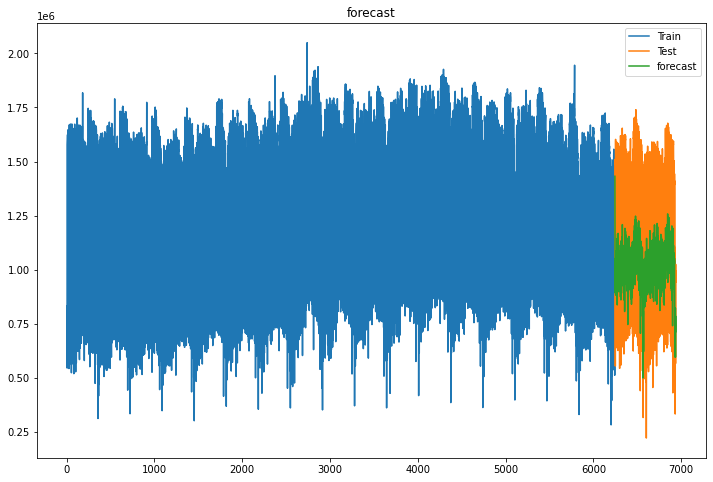

Evaluation metric results:-
MSE is : 197750025591.7568
MAE is : 416303.51959556196
RMSE is : 444690.9326619521
MAPE is : 35.17168630805091
R2 is : -0.430484865027674



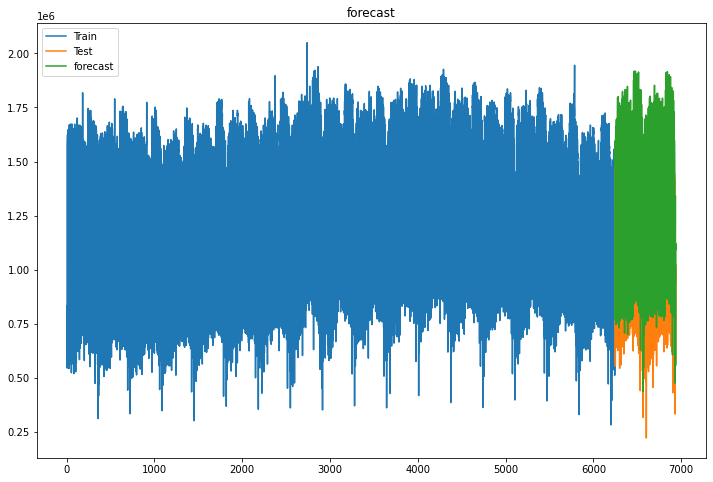

Evaluation metric results:-
MSE is : 59578993640.199196
MAE is : 189693.3975005315
RMSE is : 244088.08582189996
MAPE is : 19.54472855098226
R2 is : 0.5690172558974491



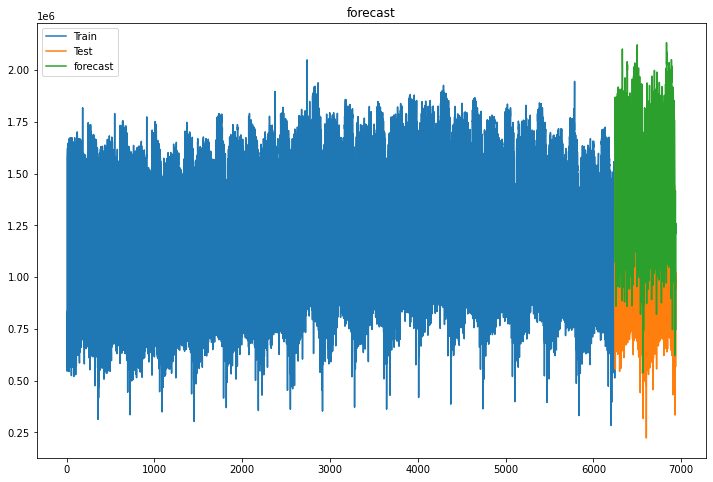

Evaluation metric results:-
MSE is : 130854038907.49214
MAE is : 320913.830636335
RMSE is : 361737.5276460712
MAPE is : 32.22056765022211
R2 is : 0.0534275703643059



In [19]:
# ------------------Fitting an Auto Regressive Light-GBM------------
# Objectives can be :- regression, regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie, binary, multiclass,
# multiclassova, cross_entropy, cross_entropy_lambda, lambdarank, rank_xendcg  

# Setting objective as 'mape' here.

params = {'objective':'quantile'}
                               #A 10 percent and 90 percent prediction interval(0.1,0.9 respectively).
alpha_params = [.1, .5, .9]    # Hyper-parameter "alpha" in Light GBM
                               #Capture forecasts for 10th/median/90th quantile, respectively.
for alpha in alpha_params:
    
    forecaster = get_transformed_target_forecaster(alpha,params)
    
    #Initialize ForecastingHorizon class to specify the horizon of forecast
    fh = ForecastingHorizon(test.index, is_relative=False)
    
    #Fit on Training data.
    forecaster.fit(train[time_dependent_variable])
    
    #Forecast the values.
    y_pred = forecaster.predict(fh)
    plot()


Now let's use lightGBM as a normal machine learning technique with input and output variables....

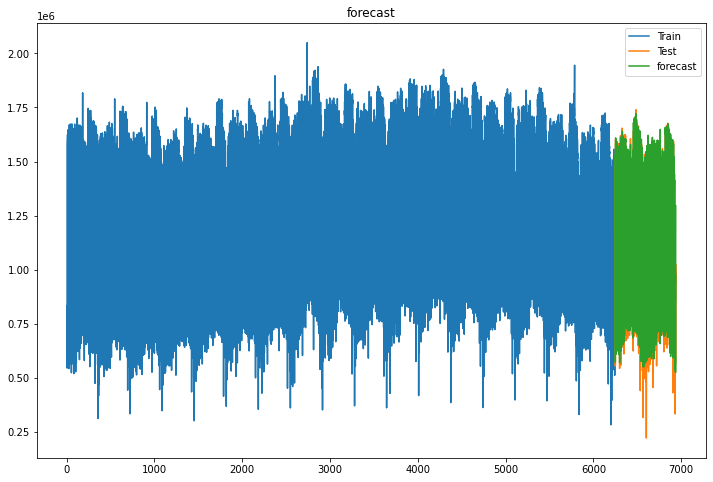

Evaluation metric results:-
MSE is : 17952034326.945126
MAE is : 70780.27142332743
RMSE is : 133985.20189537772
MAPE is : 7.948165886856587
R2 is : 0.8701385078241792



In [20]:
rg = lgb.LGBMRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

### 2) Adaboost

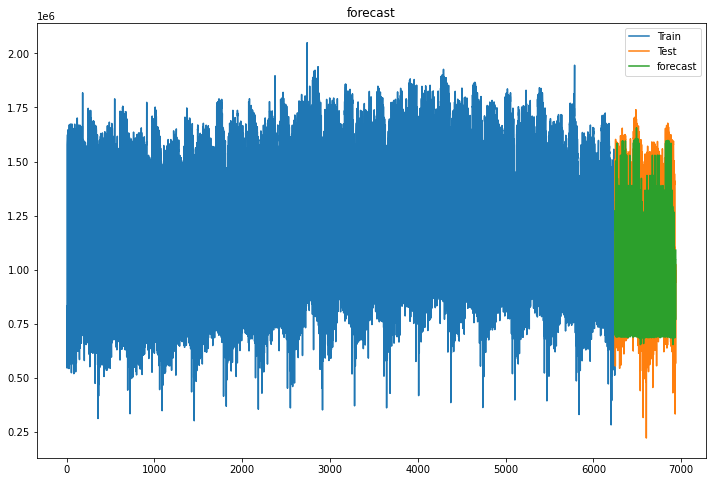

Evaluation metric results:-
MSE is : 61371971472.19964
MAE is : 203800.00339428982
RMSE is : 247733.67044509642
MAPE is : 17.87436238750082
R2 is : 0.5560472062383827



In [21]:
rg = AdaBoostRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

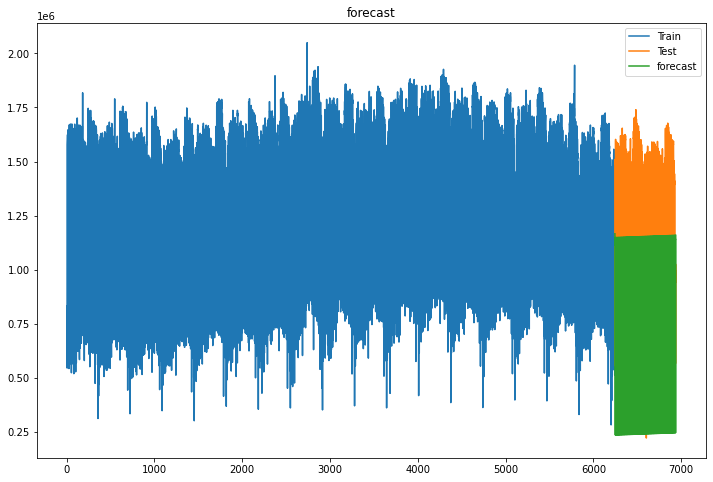

Evaluation metric results:-
MSE is : 161033336133.78793
MAE is : 387507.3377030385
RMSE is : 401289.59135989053
MAPE is : 34.890491289618744
R2 is : -0.16488354130407812



In [22]:
model(AdaBoostRegressor())

### 3) XGBoost

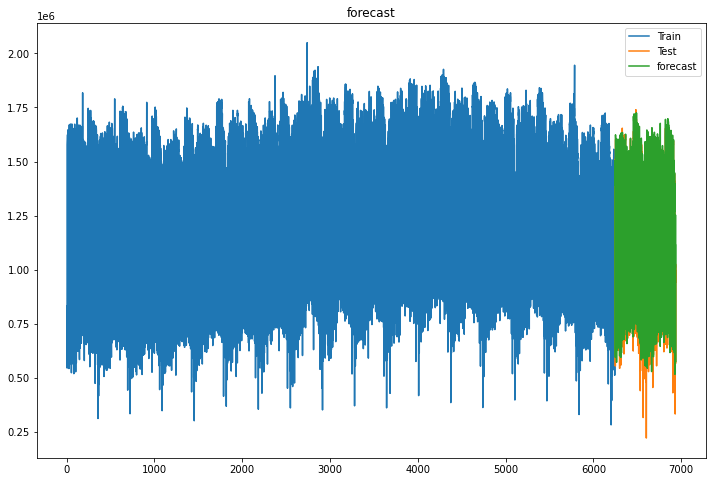

Evaluation metric results:-
MSE is : 19196509228.06536
MAE is : 74722.93385266571
RMSE is : 138551.46779469846
MAPE is : 8.362096306772864
R2 is : 0.8611362206910569



In [23]:
rg = xg.XGBRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

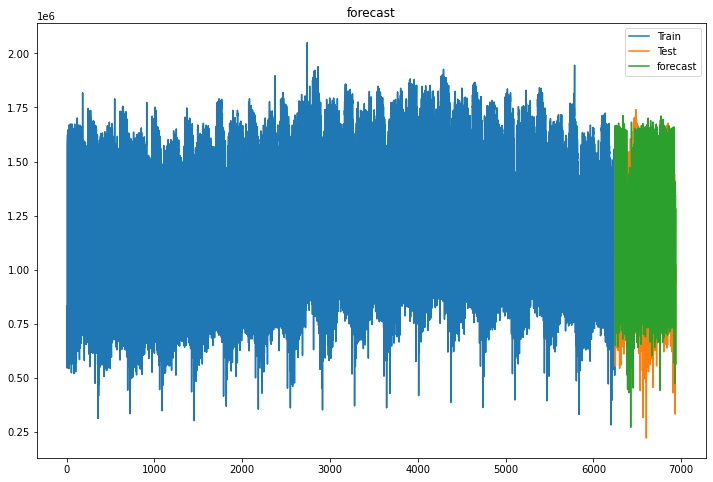

Evaluation metric results:-
MSE is : 51644781967.02759
MAE is : 150494.59274776047
RMSE is : 227254.88326332526
MAPE is : 16.175638227075755
R2 is : 0.6264117855842812



In [24]:
model(xg.XGBRegressor())

### 4) Bagged Decision Trees

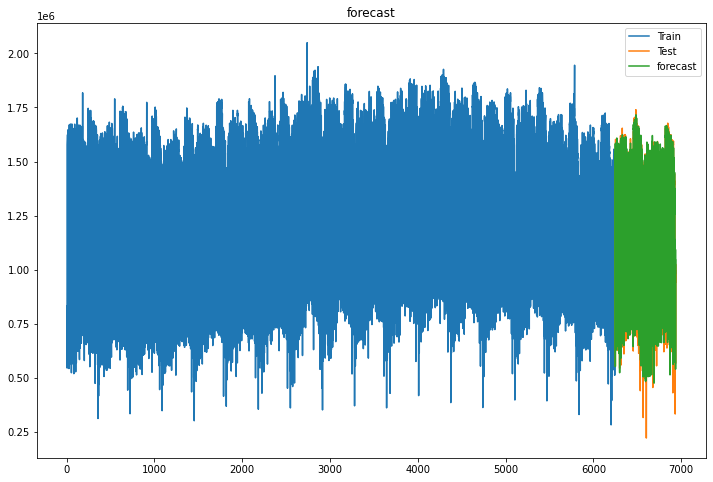

Evaluation metric results:-
MSE is : 18790065721.933403
MAE is : 72686.51412103746
RMSE is : 137076.86063640867
MAPE is : 8.093861772503102
R2 is : 0.8640763532259109



In [25]:
rg = BaggingRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

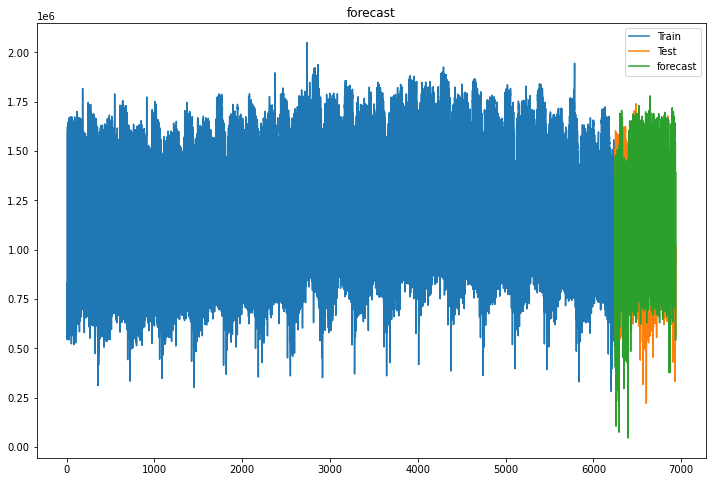

Evaluation metric results:-
MSE is : 62059605697.25154
MAE is : 168155.0346115165
RMSE is : 249117.6543267288
MAPE is : 17.916600228259817
R2 is : 0.551072995243121



In [26]:
model(BaggingRegressor())

### 5) GradientBoostingRegressor

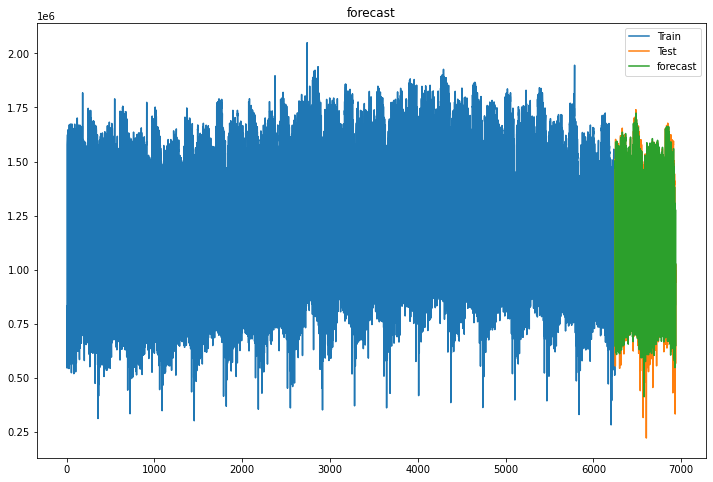

Evaluation metric results:-
MSE is : 21618336486.37299
MAE is : 76022.34145554168
RMSE is : 147031.7533268681
MAPE is : 9.008401291166166
R2 is : 0.8436171977308649



In [27]:
rg = GradientBoostingRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

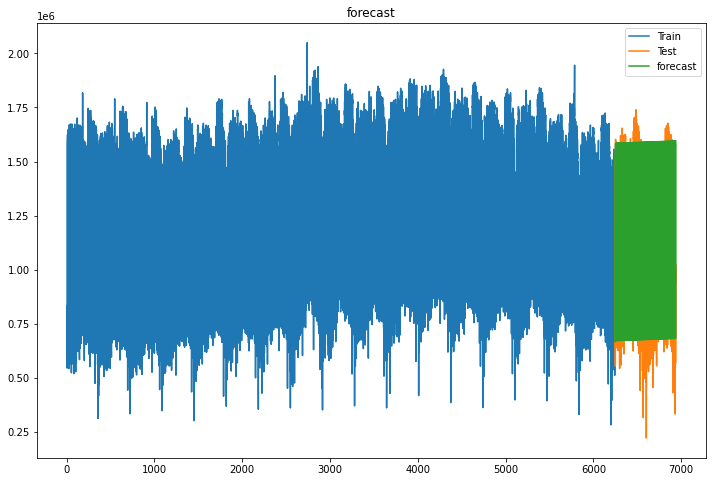

Evaluation metric results:-
MSE is : 39885521612.56451
MAE is : 108598.81570669544
RMSE is : 199713.59896753277
MAPE is : 12.8189268664541
R2 is : 0.7114759665402234



In [28]:
model(GradientBoostingRegressor())

### 6) Extra TreesRegressor

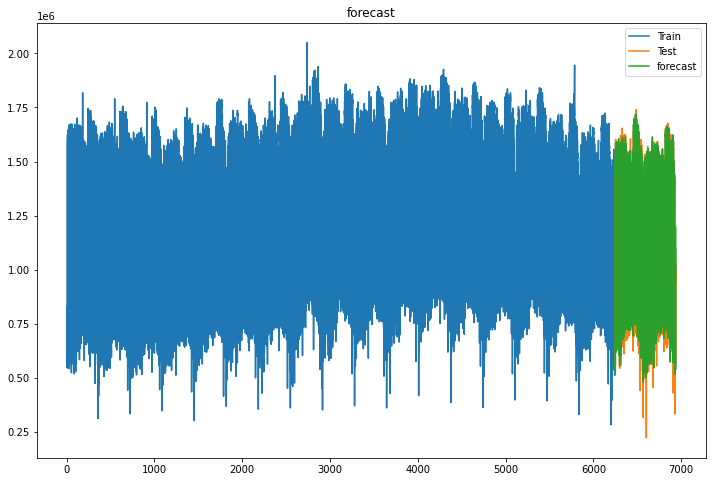

Evaluation metric results:-
MSE is : 14672858701.94907
MAE is : 65998.31792507204
RMSE is : 121131.57599052804
MAPE is : 7.263223830283438
R2 is : 0.8938594205638237



In [29]:
rg = ExtraTreesRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

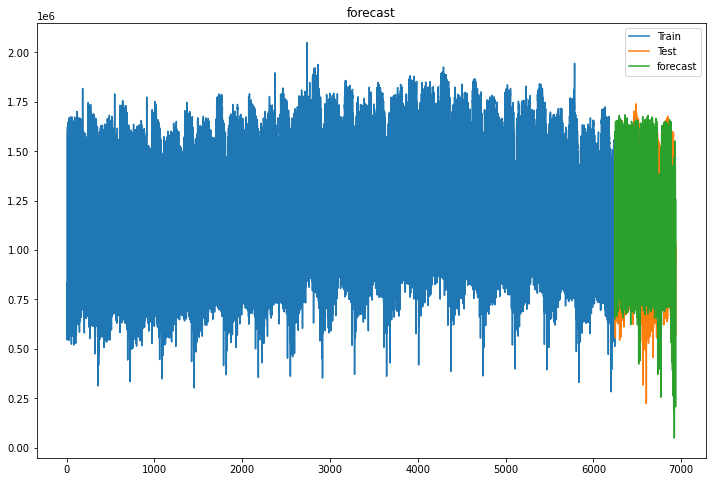

Evaluation metric results:-
MSE is : 53276131845.43895
MAE is : 149756.03431689856
RMSE is : 230816.2295971385
MAPE is : 16.30611615997148
R2 is : 0.6146109208124616



In [30]:
model(ExtraTreesRegressor())

### 7) Decision Tree Regressor

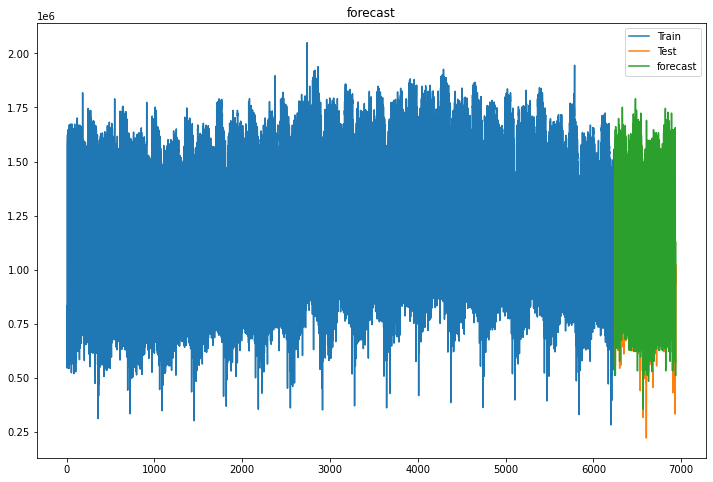

Evaluation metric results:-
MSE is : 30525899925.28098
MAE is : 96902.13688760807
RMSE is : 174716.6275008792
MAPE is : 10.331496620957363
R2 is : 0.7791816324483748



In [31]:
rg = DecisionTreeRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

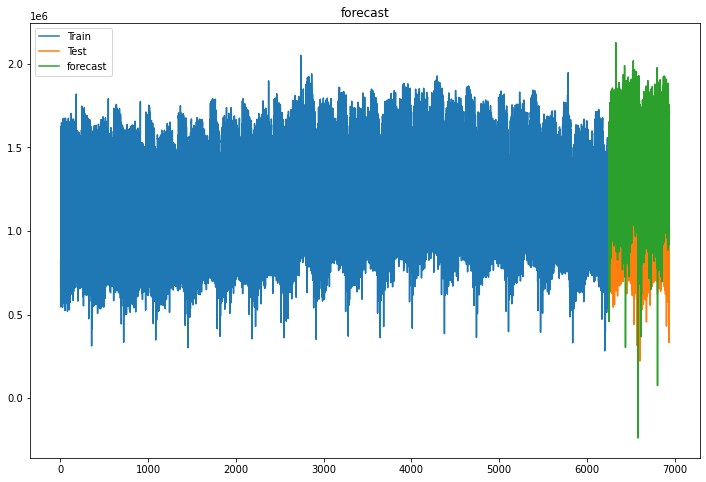

Evaluation metric results:-
MSE is : 118866492828.81107
MAE is : 276054.1091830175
RMSE is : 344770.20293060574
MAPE is : 28.232877679099445
R2 is : 0.14014312543470664



In [32]:
model(DecisionTreeRegressor())

### 8) Support Vector Regression

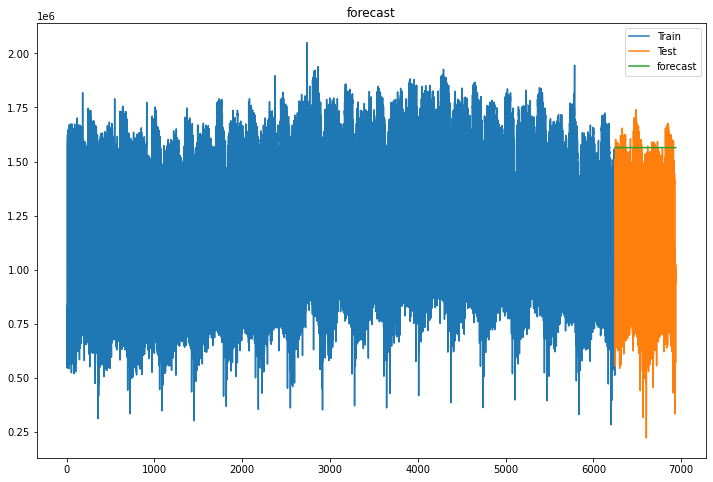

Evaluation metric results:-
MSE is : 224618129498.70624
MAE is : 314796.8123832679
RMSE is : 473938.9512360281
MAPE is : 41.403868682273036
R2 is : -0.6248434542408439



In [33]:
rg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)).fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

### 9) KNN Regression

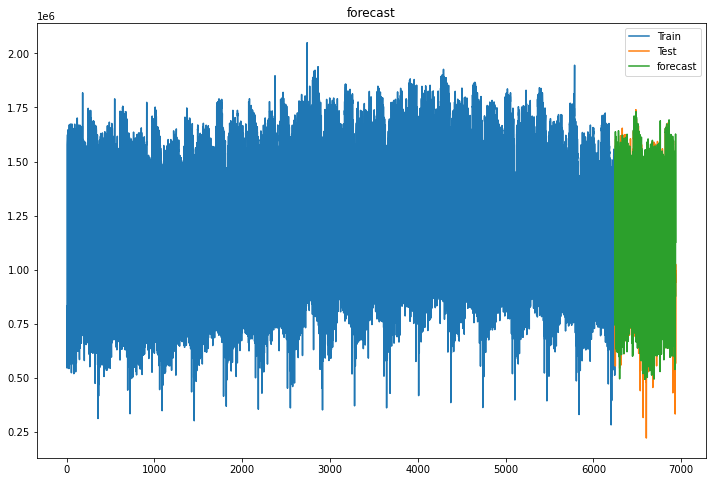

Evaluation metric results:-
MSE is : 29363708443.857292
MAE is : 90704.98270893372
RMSE is : 171358.42098904066
MAPE is : 10.556963547578963
R2 is : 0.7875886974763855



In [34]:
rg = KNeighborsRegressor(n_neighbors=5).fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

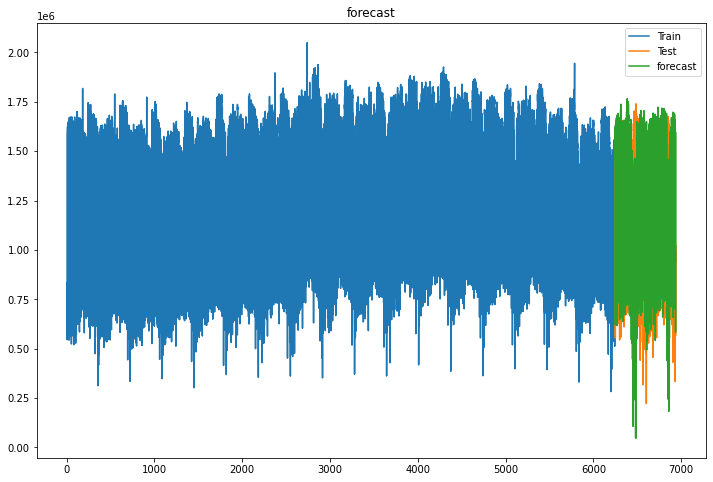

Evaluation metric results:-
MSE is : 71884478086.84355
MAE is : 174905.77426858773
RMSE is : 268112.8085094846
MAPE is : 18.29762962713965
R2 is : 0.48000179708735446



In [35]:
model(KNeighborsRegressor(n_neighbors=5))

### 10) Random Forest Regression 

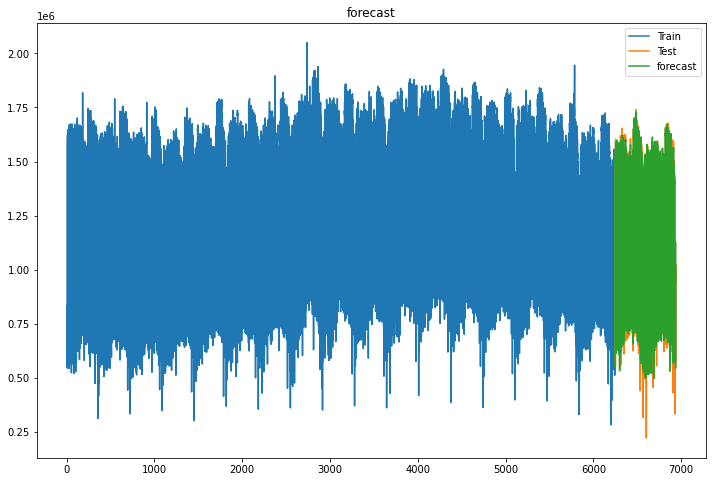

Evaluation metric results:-
MSE is : 16831908768.297125
MAE is : 67232.85034582132
RMSE is : 129737.8463221011
MAPE is : 7.613680658959841
R2 is : 0.8782412762247485



In [36]:
rg = RandomForestRegressor().fit(train_X, train_Y)
pred = rg.predict(test_X)
plot_ml()

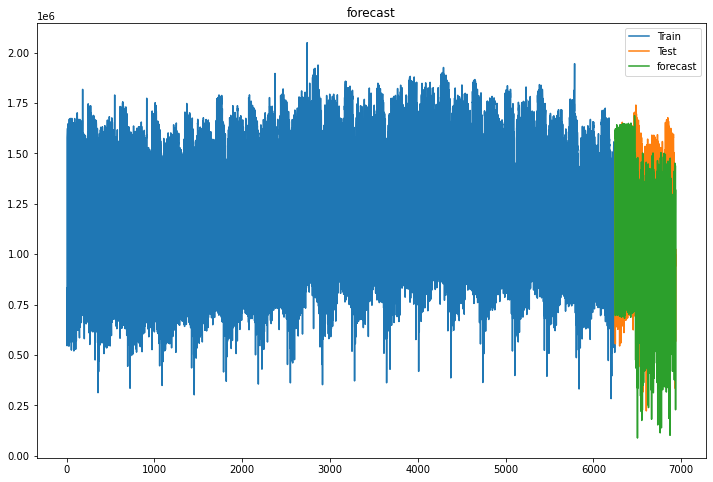

Evaluation metric results:-
MSE is : 76205259103.60681
MAE is : 210758.27520358827
RMSE is : 276053.0005336055
MAPE is : 20.255432515828257
R2 is : 0.44874611542014375



In [37]:
model(RandomForestRegressor())